Import necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For Z-score
import plotly.express as px # For interactive plots like wind rose and bubble chart

# Configure visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# Define country and load data


In [27]:
# IMPORTANT: Change this for each country notebook
COUNTRY_NAME = "Benin"
CSV_FILE_NAME = "benin-malanville.csv"

# If you uploaded directly to Colab session storage:
try:
    df = pd.read_csv(CSV_FILE_NAME)
except FileNotFoundError:
    print(f"Error: {CSV_FILE_NAME} not found. Make sure you've uploaded it to Colab.")


print(f"Successfully loaded data for {COUNTRY_NAME}")
df.head()

Successfully loaded data for Benin


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998.0,0.0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998.0,0.0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997.0,0.0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997.0,0.0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997.0,0.0,0.0,26.4,26.3,NaN


# Initial Data Inspection

In [28]:
print("--- Initial Data Info ---")
df.info()

print("\n--- Data Shape ---")
print(df.shape)

print("\n--- Data Types ---")
print(df.dtypes)

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59539 entries, 0 to 59538
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Timestamp      59539 non-null  object 
 1   GHI            59539 non-null  float64
 2   DNI            59538 non-null  float64
 3   DHI            59538 non-null  float64
 4   ModA           59538 non-null  float64
 5   ModB           59538 non-null  float64
 6   Tamb           59538 non-null  float64
 7   RH             59538 non-null  float64
 8   WS             59538 non-null  float64
 9   WSgust         59538 non-null  float64
 10  WSstdev        59538 non-null  float64
 11  WD             59538 non-null  float64
 12  WDstdev        59538 non-null  float64
 13  BP             59538 non-null  float64
 14  Cleaning       59538 non-null  float64
 15  Precipitation  59538 non-null  float64
 16  TModA          59538 non-null  float64
 17  TModB          59538 non

# Summary Statistics & Missing-Value Report


In [29]:
print("\n--- Summary Statistics (Numeric Columns) ---")
print(df.describe())

print("\n--- Missing Value Report ---")
missing_values = df.isna().sum()
print(missing_values)

print("\n--- Columns with >5% Nulls ---")
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100
columns_with_high_nulls = missing_percentage[missing_percentage > 5]
if not columns_with_high_nulls.empty:
    print(columns_with_high_nulls)
else:
    print("No columns with >5% null values.")

# Identify numeric columns for Z-score calculation later
numeric_cols_for_zscore = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# Ensure these columns are numeric
# ... (coerce to numeric as before) ...

# Check the new 'Cleaning' column
if 'Cleaning' in df.columns:
    print("\n--- Info on 'Cleaning' column (physical cleaning events) ---")
    print(df['Cleaning'].value_counts(dropna=False))
    # Convert to int if it's not, assuming it should be 0 or 1
    # df['Cleaning'] = pd.to_numeric(df['Cleaning'], errors='coerce').fillna(0).astype(int) # Example handling
else:
    print("\n'Cleaning' column (physical cleaning events) not found.")# Ensure these columns are actually numeric, coercing errors if necessary


for col in numeric_cols_for_zscore:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column {col} not found in DataFrame for Z-score calculation.")
        # Remove from list if not present to avoid errors later
        numeric_cols_for_zscore.remove(col)


# Convert Timestamp to datetime objects
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    print("\n--- Info on 'Timestamp' column ---")
    # Check if conversion resulted in NaT (Not a Time) values
    if df['Timestamp'].isna().any():
        print("\nWarning: Some Timestamp values could not be parsed and are now NaT.")
        print(f"Number of NaT in Timestamp after conversion: {df['Timestamp'].isna().sum()}")
else:
    print("\nWarning: 'Timestamp' column not found.")


--- Summary Statistics (Numeric Columns) ---
                GHI           DNI           DHI          ModA          ModB  \
count  59539.000000  59538.000000  59538.000000  59538.000000  59538.000000   
mean     204.907536    103.805585    122.137148    193.274351    193.330475   
std      307.245962    218.962733    170.943363    290.280434    290.385332   
min       -7.300000     -3.000000     -6.200000      0.000000      0.000000   
25%       -1.400000     -0.200000     -1.300000      0.000000      0.000000   
50%        2.900000     -0.100000      2.900000      4.300000      4.300000   
75%      341.900000     33.900000    230.400000    317.250000    317.250000   
max     1413.000000    904.000000    715.700000   1342.300000   1342.300000   

               Tamb            RH            WS        WSgust       WSstdev  \
count  59538.000000  59538.000000  59538.000000  59538.000000  59538.000000   
mean      26.750380     85.256251      1.679015      2.310889      0.431157   
std  

# Outlier Detection & Basic Cleaning


In [30]:
# --- REVISED CELL 6 ---
# Goal: Identify outliers, flag them, AND THEN create df_cleaned.
# The flagged DataFrame can be used by Cell 8.

print("\n--- Cell 6: Outlier Detection, Flagging, and Cleaning ---")

# 0. Start with a working copy that will get the flags
df_main_working_copy = df.copy() # This copy will receive the outlier_flag

# 1. Address Obvious Data Errors (e.g., Negative Irradiance)
# Apply these fixes to df_main_working_copy
print("\nStep 1: Addressing physically impossible values...")
irradiance_cols = ['GHI', 'DNI', 'DHI']
for col in irradiance_cols:
    if col in df_main_working_copy.columns:
        negative_values_count = (df_main_working_copy[col] < 0).sum()
        if negative_values_count > 0:
            print(f"Found {negative_values_count} negative values in '{col}'. Clipping them to 0.")
            df_main_working_copy.loc[df_main_working_copy[col] < 0, col] = 0

# 2. Prepare a sub-copy specifically for Z-score calculation
# This sub-copy gets imputations ONLY for Z-score robustness.
# df_main_working_copy retains original values where possible, only GHI etc. clipped.
df_for_zscore_calc_only = df_main_working_copy.copy() # Sub-copy for Z-score calc pre-processing

key_numeric_cols_for_imputation_zscore = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust'] # Only Z-score cols
key_numeric_cols_for_imputation_zscore = [col for col in key_numeric_cols_for_imputation_zscore if col in df_for_zscore_calc_only.columns]

print("\nStep 2: Imputing missing values (median) in Z-score columns for calculation robustness...")
for col in key_numeric_cols_for_imputation_zscore:
    if df_for_zscore_calc_only[col].isna().any():
        median_val_z = df_for_zscore_calc_only[col].median()
        df_for_zscore_calc_only[col].fillna(median_val_z, inplace=True)
        # print(f"Imputed NaNs in '{col}' (for Z-score calc only) with median: {median_val_z:.2f}")

# 3. Outlier Detection using Z-scores and FLAG on df_main_working_copy
print("\nStep 3: Outlier Detection (Z-scores) and Flagging...")
z_score_cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_score_cols_to_check = [col for col in z_score_cols_to_check if col in df_for_zscore_calc_only.columns]

df_main_working_copy['outlier_flag'] = False # Initialize flag on the main working copy

if not z_score_cols_to_check:
    print("No columns for Z-score checking.")
else:
    combined_outlier_mask = pd.Series(False, index=df_for_zscore_calc_only.index)
    for col in z_score_cols_to_check:
        col_data = df_for_zscore_calc_only[col] # Use the Z-score prepped data
        if col_data.std() == 0: continue
        z_scores = np.abs(stats.zscore(col_data)) # Assumes col_data is already imputed
        column_specific_mask = pd.Series(z_scores > 3, index=col_data.index)
        combined_outlier_mask = combined_outlier_mask | column_specific_mask

    # Apply the combined mask to set the flag on df_main_working_copy
    # The indices of combined_outlier_mask align with df_main_working_copy
    df_main_working_copy.loc[combined_outlier_mask, 'outlier_flag'] = True

outlier_rows_count = df_main_working_copy['outlier_flag'].sum()
print(f"Number of rows flagged as outliers: {outlier_rows_count}")
# At this point, df_main_working_copy has all original rows, GHI/DNI/DHI clipped, and an 'outlier_flag'.
# ModA, ModB, etc., in df_main_working_copy are still their original values (unless they were GHI/DNI/DHI).
# This df_main_working_copy is now PERFECT for Cell 8, Part 1.

# 4. Create the Cleaned DataFrame (df_cleaned) by removing flagged outliers
print("\nStep 4: Creating df_cleaned by removing flagged outliers...")
df_cleaned = df_main_working_copy[~df_main_working_copy['outlier_flag']].copy()
# Now, df_cleaned does NOT have the outlier_flag column from df_main_working_copy unless we explicitly copy it.
# Let's drop it from df_cleaned as it has served its purpose for filtering.
if 'outlier_flag' in df_cleaned.columns: # Should not be there due to boolean indexing unless selected
    df_cleaned = df_main_working_copy[~df_main_working_copy['outlier_flag']].drop(columns=['outlier_flag']).copy()
else: # More likely path
    df_cleaned = df_main_working_copy[~df_main_working_copy['outlier_flag']].copy()
    # We also want to remove the outlier_flag from df_cleaned if it somehow got there
    # The above filtering selects rows, and all columns from df_main_working_copy for those rows, *including outlier_flag*.
    # So, we must drop it from df_cleaned AFTER filtering.
    if 'outlier_flag' in df_cleaned.columns:
         df_cleaned.drop(columns=['outlier_flag'], inplace=True)


# 5. Further Cleaning on df_cleaned (e.g., impute other columns, drop 'Comments')
print("\nStep 5: Performing further cleaning on df_cleaned...")
# Impute missing values in other key columns in df_cleaned (if not already handled or if new NaNs appeared)
key_numeric_cols_final_imputation = ['Tamb', 'RH', 'BP', 'Precipitation',
                                     'WSstdev', 'WDstdev', 'TModA', 'TModB'] # Excludes Z-score cols already considered
key_numeric_cols_final_imputation = [col for col in key_numeric_cols_final_imputation if col in df_cleaned.columns]

for col in key_numeric_cols_final_imputation:
    if df_cleaned[col].isna().any():
        median_val_cleaned = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val_cleaned, inplace=True)
        print(f"Imputed NaNs in '{col}' (in df_cleaned) with median: {median_val_cleaned:.2f}")

if 'Timestamp' in df_cleaned.columns and df_cleaned['Timestamp'].isna().any():
    df_cleaned.dropna(subset=['Timestamp'], inplace=True)
if 'Comments' in df_cleaned.columns:
    df_cleaned.drop(columns=['Comments'], inplace=True)

# 6. Report and Export df_cleaned
# ... (same as before) ...
print(f"\nShape of original df: {df.shape}")
print(f"Shape of df_main_working_copy (with flag, pre-removal): {df_main_working_copy.shape}")
print(f"Shape of df_cleaned: {df_cleaned.shape}")
# ... export df_cleaned ...


--- Cell 6: Outlier Detection, Flagging, and Cleaning ---

Step 1: Addressing physically impossible values...
Found 28929 negative values in 'GHI'. Clipping them to 0.
Found 31309 negative values in 'DNI'. Clipping them to 0.
Found 28753 negative values in 'DHI'. Clipping them to 0.

Step 2: Imputing missing values (median) in Z-score columns for calculation robustness...

Step 3: Outlier Detection (Z-scores) and Flagging...
Number of rows flagged as outliers: 2819

Step 4: Creating df_cleaned by removing flagged outliers...

Step 5: Performing further cleaning on df_cleaned...
Imputed NaNs in 'Tamb' (in df_cleaned) with median: 26.10
Imputed NaNs in 'RH' (in df_cleaned) with median: 90.40
Imputed NaNs in 'BP' (in df_cleaned) with median: 995.00
Imputed NaNs in 'Precipitation' (in df_cleaned) with median: 0.00
Imputed NaNs in 'WSstdev' (in df_cleaned) with median: 0.40
Imputed NaNs in 'WDstdev' (in df_cleaned) with median: 6.90
Imputed NaNs in 'TModA' (in df_cleaned) with median: 27.0

<ipython-input-30-ee4502132002>:33: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-30-ee4502132002>:90: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

# Time Series Analysis (using df_cleaned)



--- Time Series Analysis ---
Plotting time series for: GHI, DNI, DHI, Tamb, TModA, TModB


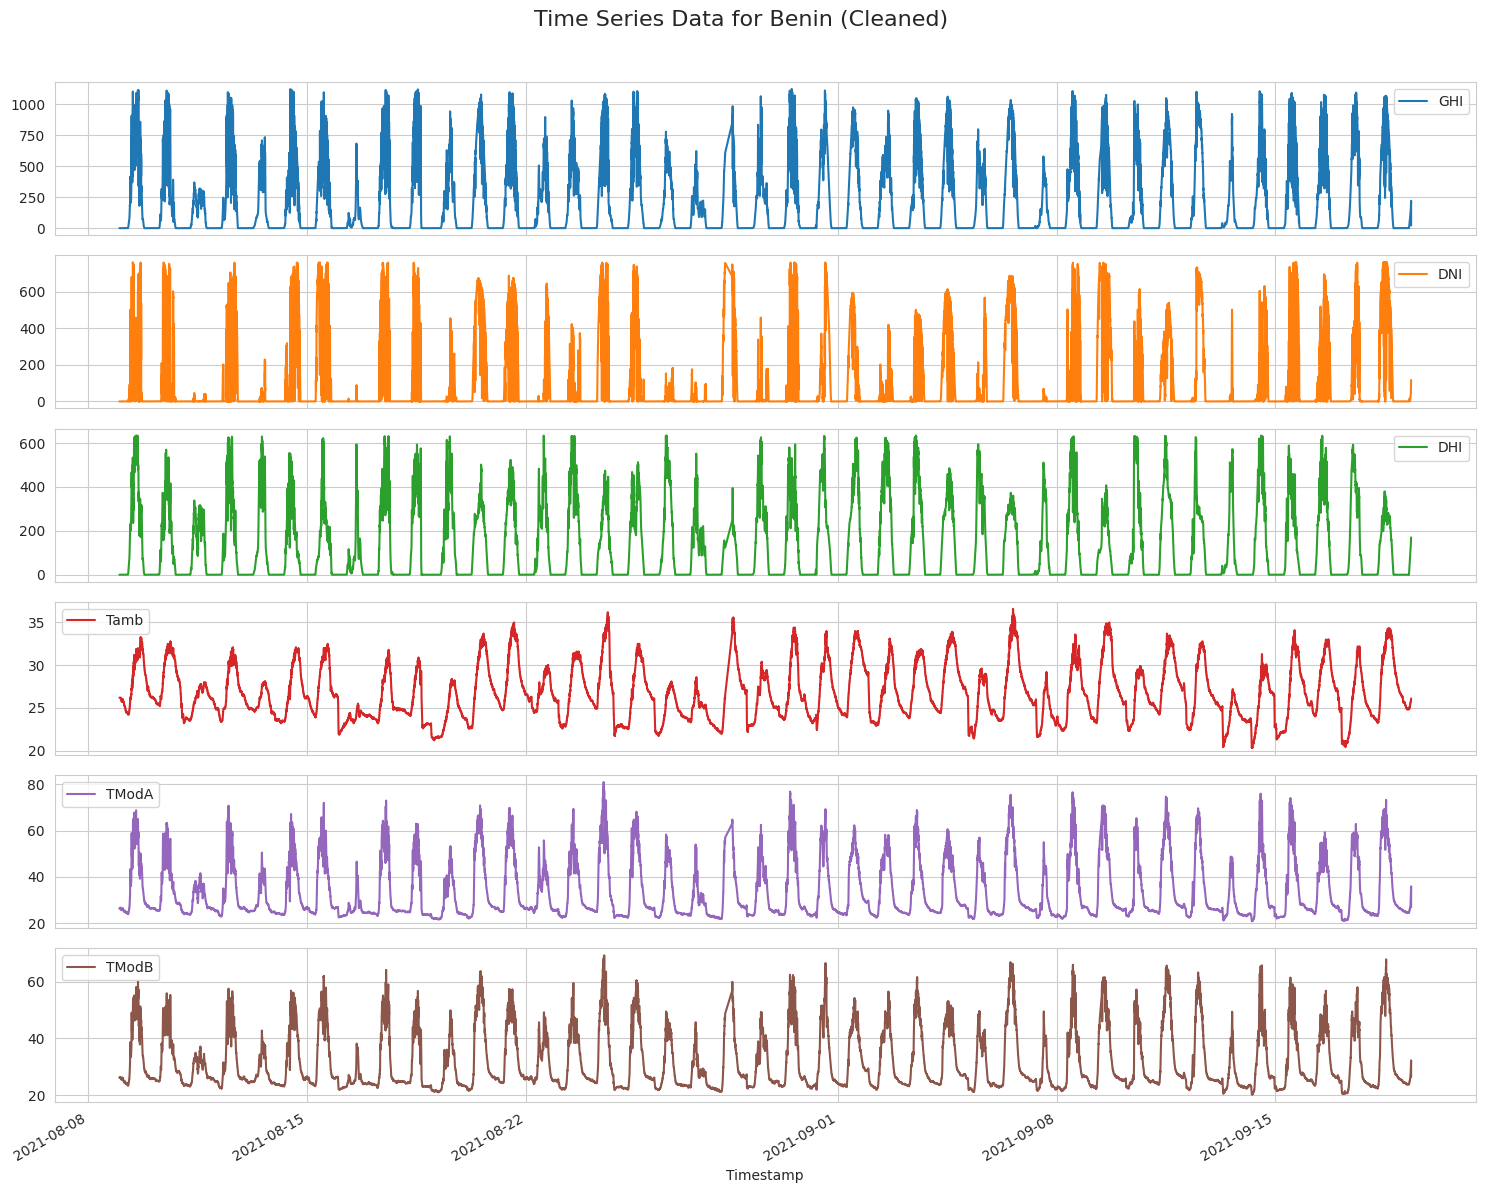


Analyzing monthly patterns...


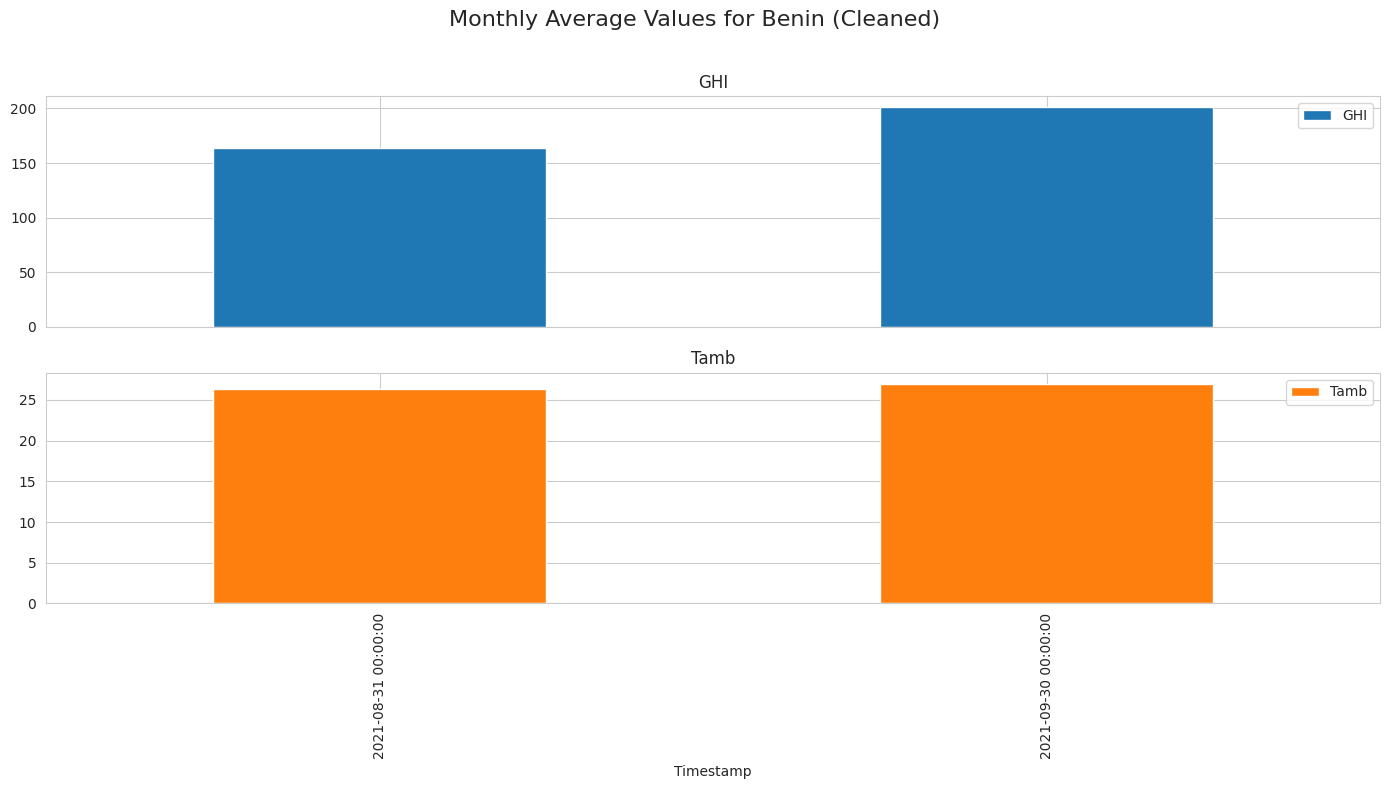


Analyzing hourly patterns (trends throughout the day)...


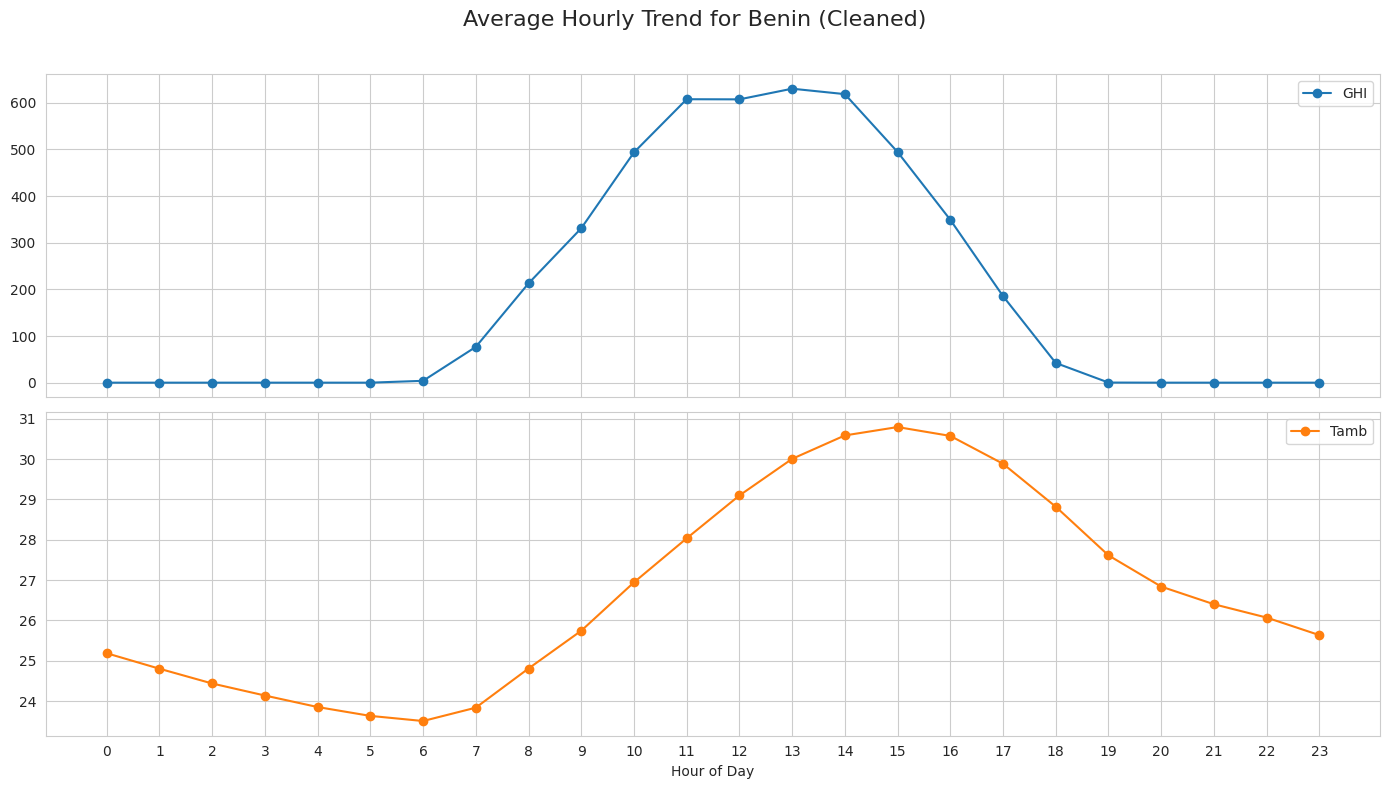

--- End of Time Series Analysis ---


In [31]:
print("\n--- Time Series Analysis ---")

if 'Timestamp' not in df_cleaned.columns or df_cleaned['Timestamp'].isna().all():
    print("Skipping Time Series Analysis: 'Timestamp' column is missing, not datetime, or all NaT in df_cleaned.")
else:
    # Ensure Timestamp is datetime (should be from previous steps, but good to double-check or re-assert)
    df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])

    # Set Timestamp as index for easy plotting and resampling
    # Make a copy to avoid SettingWithCopyWarning if df_ts is modified later
    df_ts = df_cleaned.set_index('Timestamp').copy()

    # --- Plot 1: Key variables over time ---
    cols_to_plot_timeseries = ['GHI', 'DNI', 'DHI', 'Tamb']
    # Add TModA and TModB if they exist
    if 'TModA' in df_ts.columns: cols_to_plot_timeseries.append('TModA')
    if 'TModB' in df_ts.columns: cols_to_plot_timeseries.append('TModB')

    # Filter out columns not present in df_ts
    cols_to_plot_timeseries = [col for col in cols_to_plot_timeseries if col in df_ts.columns]

    if not cols_to_plot_timeseries:
        print("No key columns (GHI, DNI, DHI, Tamb, TModA, TModB) available for Time Series plotting.")
    else:
        print(f"Plotting time series for: {', '.join(cols_to_plot_timeseries)}")
        # Plotting each on a separate subplot for clarity
        df_ts[cols_to_plot_timeseries].plot(subplots=True, figsize=(15, 2*len(cols_to_plot_timeseries)),
                                            title=f'Time Series Data for {COUNTRY_NAME} (Cleaned)',
                                            sharex=True) # Share x-axis for easier comparison
        plt.xlabel("Timestamp") # Common x-label
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for main title
        plt.suptitle(f'Time Series Data for {COUNTRY_NAME} (Cleaned)', fontsize=16, y=0.99) # Main title workaround
        plt.show()

        # --- Plot 2: Patterns by month (Example: Monthly average GHI and Tamb) ---
        print("\nAnalyzing monthly patterns...")
        monthly_cols_to_analyze = ['GHI', 'Tamb']
        monthly_cols_to_analyze = [col for col in monthly_cols_to_analyze if col in df_ts.columns]

        if monthly_cols_to_analyze:
            try:
                # 'M' was deprecated, use 'ME' for month end frequency or 'MS' for month start
                monthly_avg = df_ts[monthly_cols_to_analyze].resample('ME').mean()

                if not monthly_avg.empty:
                    monthly_avg.plot(kind='bar', subplots=True, figsize=(14, 8),
                                     title=f'Monthly Average Values for {COUNTRY_NAME} (Cleaned)')
                    plt.tight_layout(rect=[0, 0, 1, 0.96])
                    plt.suptitle(f'Monthly Average Values for {COUNTRY_NAME} (Cleaned)', fontsize=16, y=0.98)
                    plt.show()
                else:
                    print("No data after resampling by month.")
            except Exception as e:
                print(f"Could not resample for monthly averages: {e}")
        else:
            print("GHI or Tamb column not available for monthly average plot.")

        # --- Plot 3: Trends throughout the day (Example: Average GHI and Tamb by hour) ---
        print("\nAnalyzing hourly patterns (trends throughout the day)...")
        hourly_cols_to_analyze = ['GHI', 'Tamb']
        hourly_cols_to_analyze = [col for col in hourly_cols_to_analyze if col in df_ts.columns]

        if hourly_cols_to_analyze:
            if not df_ts.index.is_monotonic_increasing and not df_ts.index.is_monotonic_decreasing:
                 print("Warning: Timestamp index is not monotonic. Sorting index for hourly aggregation.")
                 df_ts.sort_index(inplace=True)

            try:
                df_ts['Hour'] = df_ts.index.hour
                hourly_avg = df_ts.groupby('Hour')[hourly_cols_to_analyze].mean()

                if not hourly_avg.empty:
                    hourly_avg.plot(kind='line', marker='o', subplots=True, figsize=(14, 8),
                                    title=f'Average Hourly Trend for {COUNTRY_NAME} (Cleaned)')
                    plt.xticks(range(0,24))
                    plt.xlabel("Hour of Day")
                    plt.grid(True)
                    plt.tight_layout(rect=[0, 0, 1, 0.96])
                    plt.suptitle(f'Average Hourly Trend for {COUNTRY_NAME} (Cleaned)', fontsize=16, y=0.98)
                    plt.show()
                else:
                    print("No data after grouping by hour.")
                # df_ts.drop(columns=['Hour'], inplace=True) # Clean up added column if not needed later
            except Exception as e:
                print(f"Could not group by hour for hourly averages: {e}")
        else:
            print("GHI or Tamb column not available for hourly average plot.")

print("--- End of Time Series Analysis ---")

# Cleaning Impact Analysis


 Cleaning Impact Analysis ---

Part 1: Analyzing the impact of Z-score based outlier removal on ModA & ModB...

Average ModA & ModB by Z-score Outlier Flag (True=Z-score outlier, False=kept):
                    ModA        ModB
outlier_flag                        
False         169.389566  169.414216
True          673.842320  674.531713


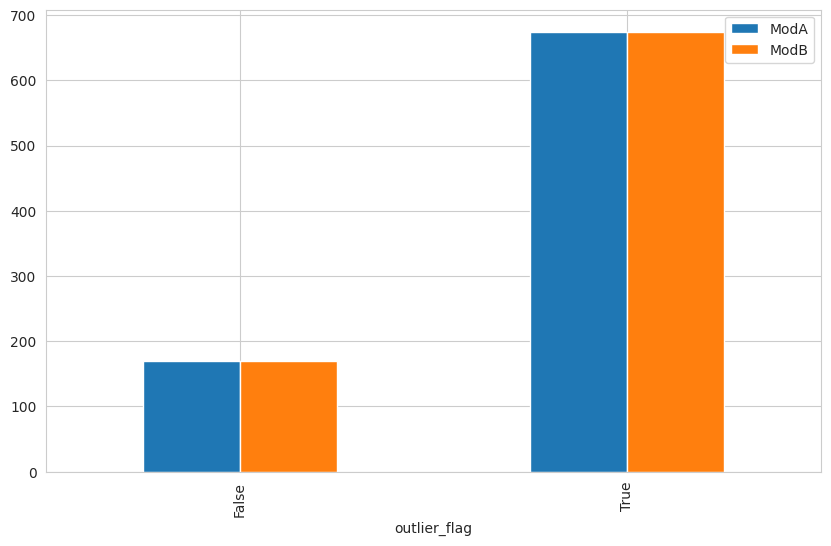


Part 2: Analyzing the impact of physical sensor cleaning events ('Cleaning' column)...

Average sensor readings by physical 'Cleaning' event status (1=cleaned this interval, 0=not):
                ModA        ModB         GHI
Cleaning                                    
0.0       193.193430  193.237551  204.811292
1.0       279.226786  292.032143  310.401786


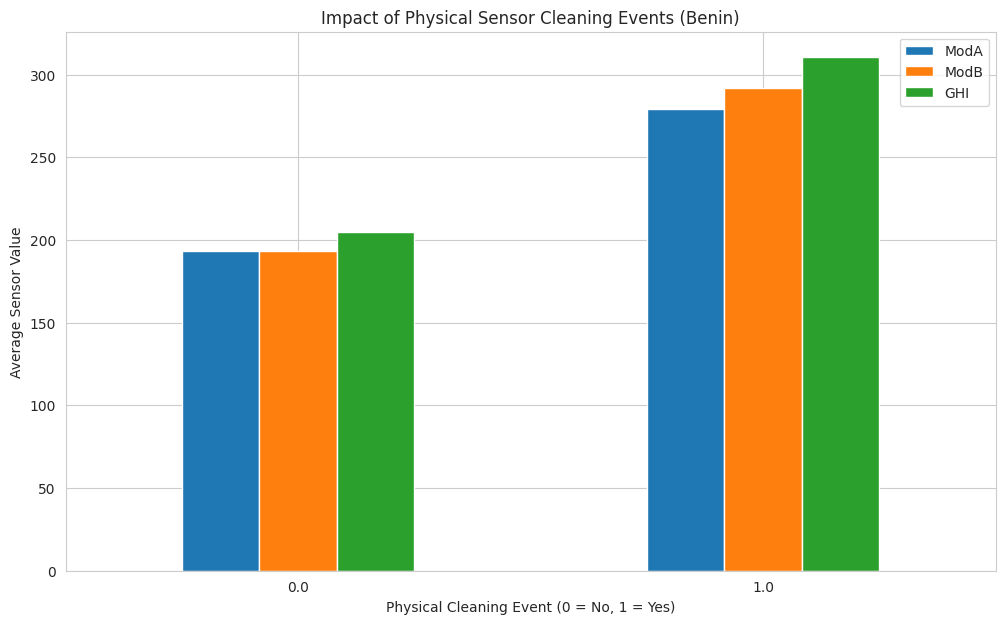

--- End of Cleaning Impact Analysis ---


In [32]:
# --- REVISED CELL 8, Part 1 ---
print("\n Cleaning Impact Analysis ---")
print("\nPart 1: Analyzing the impact of Z-score based outlier removal on ModA & ModB...")

cols_for_impact_plot = ['ModA', 'ModB']
cols_for_impact_plot = [col for col in cols_for_impact_plot if col in df_main_working_copy.columns]

if not cols_for_impact_plot:
    print("ModA or ModB columns not found in df_main_working_copy. Skipping Z-score cleaning impact plot.")
elif 'outlier_flag' not in df_main_working_copy.columns:
    print("'outlier_flag' not found in df_main_working_copy. Skipping Z-score cleaning impact plot.")
else:
    if df_main_working_copy['outlier_flag'].nunique() < 2 : # Check if there are both True and False flags
        print(f"Not enough variation in 'outlier_flag' ({df_main_working_copy['outlier_flag'].unique()}) to plot impact.")
    else:
        try:
            impact_analysis_zscore = df_main_working_copy.groupby('outlier_flag')[cols_for_impact_plot].mean()
            print("\nAverage ModA & ModB by Z-score Outlier Flag (True=Z-score outlier, False=kept):")
            print(impact_analysis_zscore)

            impact_analysis_zscore.plot(kind='bar', figsize=(10, 6))
            # ... (rest of plotting code) ...
            plt.show()
        except Exception as e:
            print(f"Error during Z-score cleaning impact analysis: {e}")

# --- Part 2: Impact of Physical Sensor Cleaning (using the 'Cleaning' column) ---
print("\nPart 2: Analyzing the impact of physical sensor cleaning events ('Cleaning' column)...")

if 'Cleaning' not in df.columns: # Check in the original df
    print("'Cleaning' column not found in the original DataFrame. Skipping physical cleaning impact analysis.")
else:
    # Ensure 'Cleaning' column is numeric (0 or 1)
    if not pd.api.types.is_numeric_dtype(df['Cleaning']):
        print("Warning: 'Cleaning' column is not numeric. Attempting to convert.")
        df['Cleaning'] = pd.to_numeric(df['Cleaning'], errors='coerce')
        # Handle potential NaNs from coercion if necessary, e.g., fill with 0 or drop
        df.dropna(subset=['Cleaning'], inplace=True) # Or df['Cleaning'].fillna(0, inplace=True)

    # Columns to check for impact of physical cleaning
    cols_for_physical_cleaning_impact = ['ModA', 'ModB', 'GHI'] # GHI can also be affected by soiling
    cols_for_physical_cleaning_impact = [col for col in cols_for_physical_cleaning_impact if col in df.columns]

    if not cols_for_physical_cleaning_impact:
        print("No suitable columns (ModA, ModB, GHI) found for physical cleaning impact analysis.")
    elif df['Cleaning'].nunique() < 2: # Check if there are both 0s and 1s
        print(f"Not enough variation in 'Cleaning' column to analyze impact (Values: {df['Cleaning'].unique()}).")
        print(df['Cleaning'].value_counts())
    else:
        try:

            physical_cleaning_impact = df.groupby('Cleaning')[cols_for_physical_cleaning_impact].mean()
            print(f"\nAverage sensor readings by physical 'Cleaning' event status (1=cleaned this interval, 0=not):")
            print(physical_cleaning_impact)

            physical_cleaning_impact.plot(kind='bar', figsize=(12, 7))
            plt.title(f'Impact of Physical Sensor Cleaning Events ({COUNTRY_NAME})')
            plt.ylabel('Average Sensor Value')
            plt.xlabel('Physical Cleaning Event (0 = No, 1 = Yes)')
            plt.xticks(rotation=0)
            plt.show()



        except Exception as e:
            print(f"Error during physical 'Cleaning' column impact analysis: {e}")

print("--- End of Cleaning Impact Analysis ---")

# Correlation & Relationship Analysis (using df_cleaned)


--- Correlation & Relationship Analysis ---


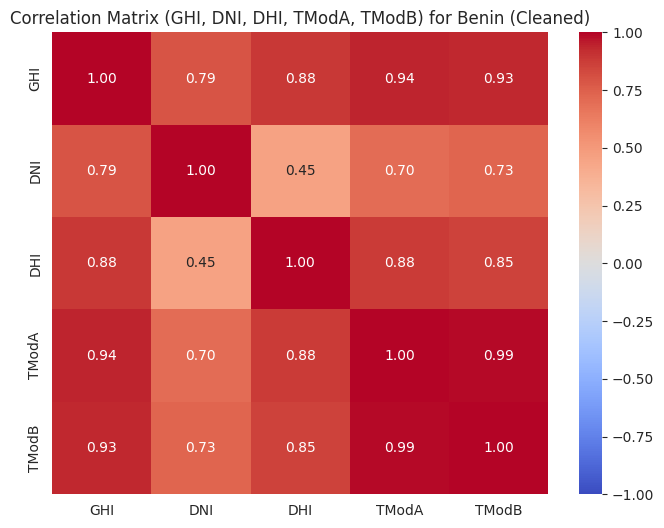

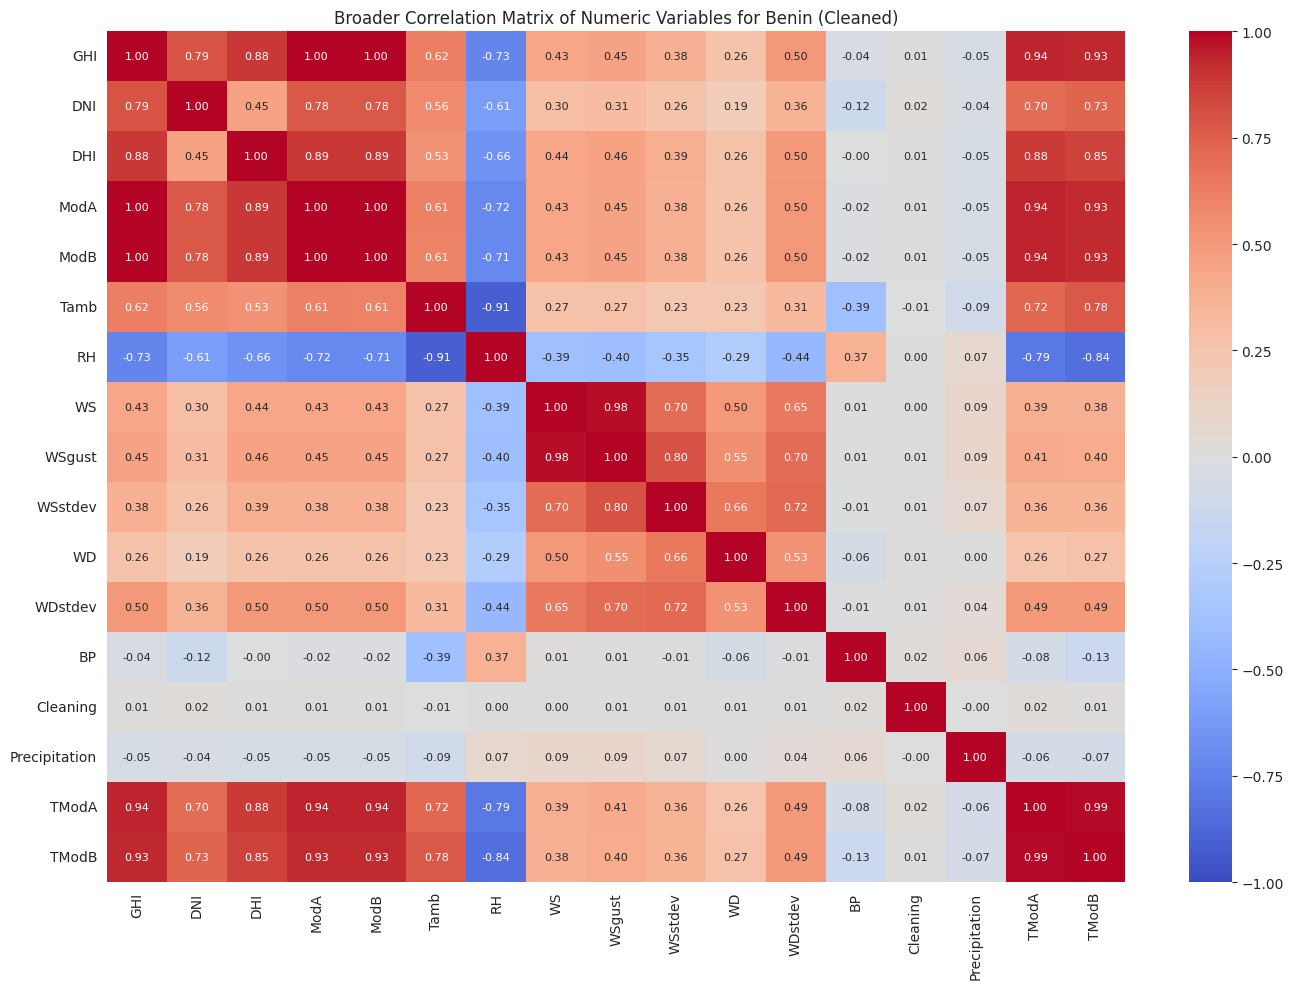

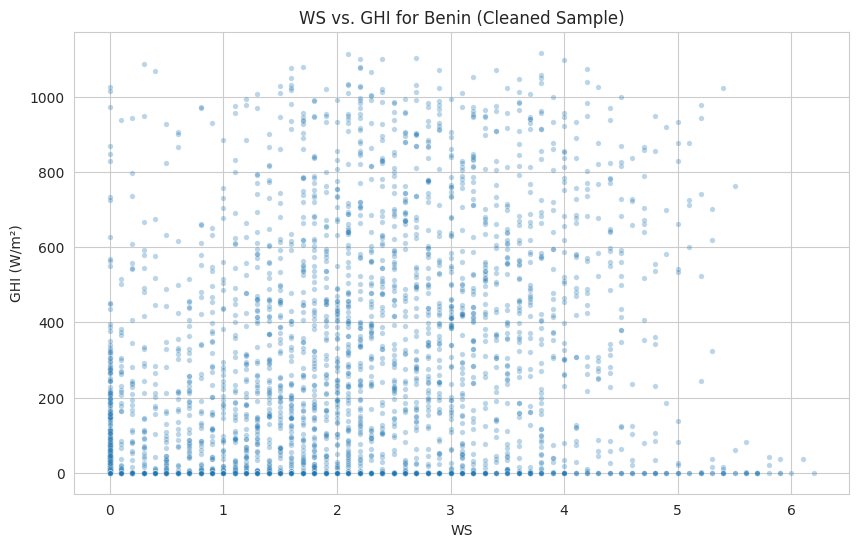

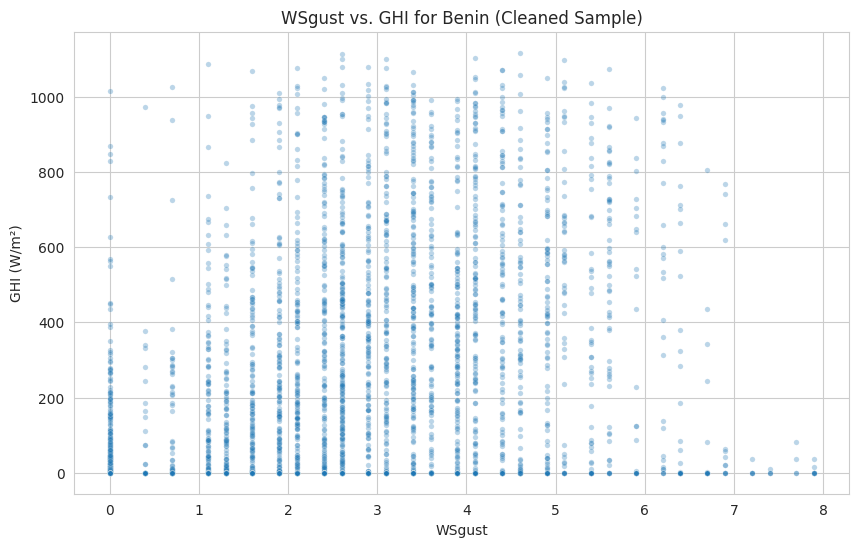

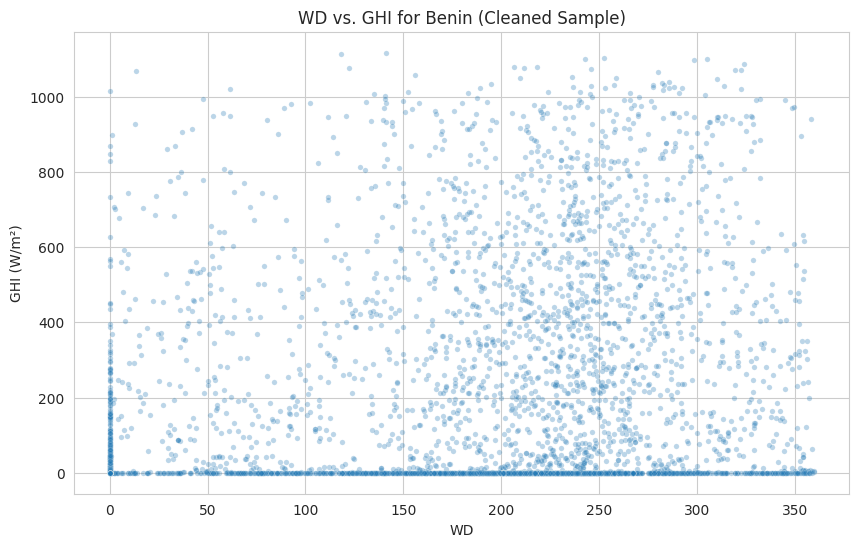

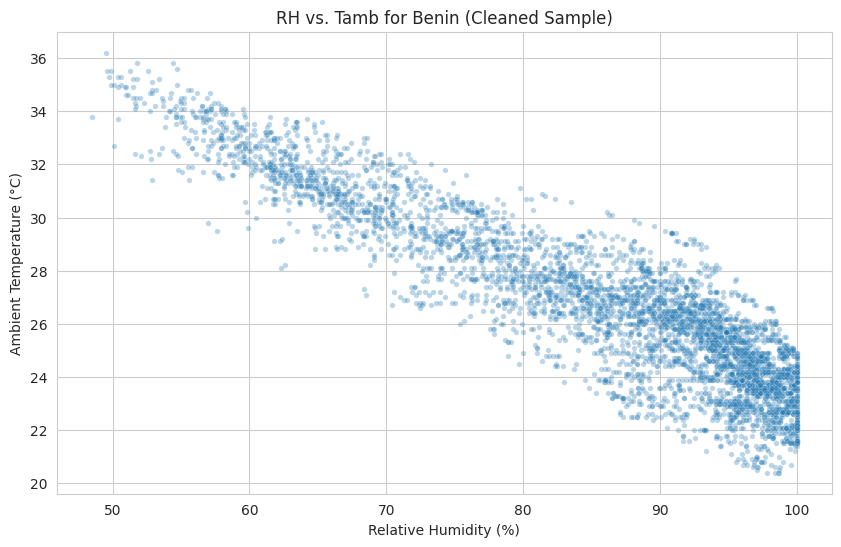

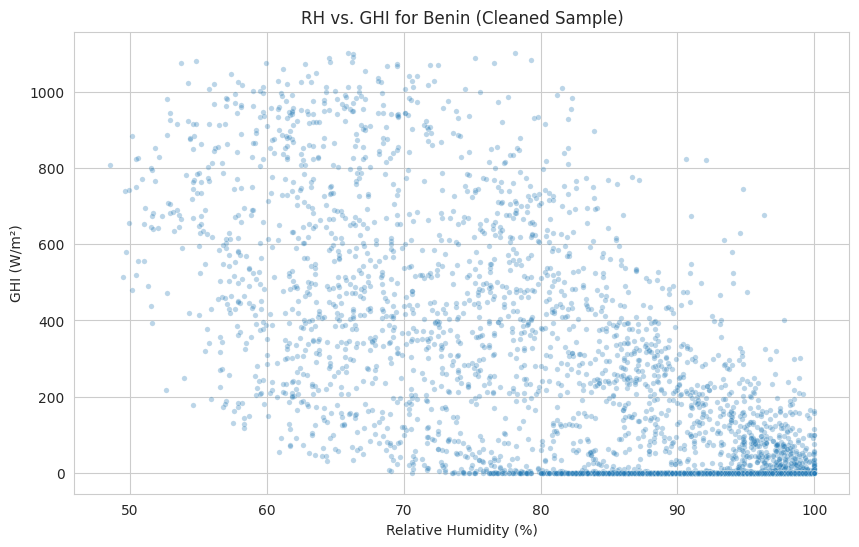

--- End of Correlation & Relationship Analysis ---


In [33]:
print("\n--- Correlation & Relationship Analysis ---")

# --- Plot 1: Heatmap of correlations (GHI, DNI, DHI, TModA, TModB) ---
# These are the specifically requested columns for the heatmap.
corr_cols_heatmap = ['GHI', 'DNI', 'DHI']
if 'TModA' in df_cleaned.columns: corr_cols_heatmap.append('TModA')
if 'TModB' in df_cleaned.columns: corr_cols_heatmap.append('TModB')
# Filter out columns not present
corr_cols_heatmap = [col for col in corr_cols_heatmap if col in df_cleaned.columns]

if len(corr_cols_heatmap) > 1:
    plt.figure(figsize=(8, 6))
    correlation_matrix_specific = df_cleaned[corr_cols_heatmap].corr()
    sns.heatmap(correlation_matrix_specific, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix (GHI, DNI, DHI, TModA, TModB) for {COUNTRY_NAME} (Cleaned)')
    plt.show()
else:
    print(f"Not enough columns ({corr_cols_heatmap}) for the specified TMod correlation heatmap.")

# --- Optional: Broader correlation matrix for all numeric types ---
# Select all numeric columns from df_cleaned
numeric_df_cleaned = df_cleaned.select_dtypes(include=np.number)
# Remove any ID-like or binary columns that might not be interesting for correlation here (e.g. 'Cleaning' if it was kept)
cols_to_exclude_from_broad_corr = [] # e.g. ['Cleaning'] if it's binary and you don't want it
numeric_df_cleaned_for_corr = numeric_df_cleaned.drop(columns=cols_to_exclude_from_broad_corr, errors='ignore')

if len(numeric_df_cleaned_for_corr.columns) > 1:
    plt.figure(figsize=(14, 10)) # May need larger figure
    broader_correlation_matrix = numeric_df_cleaned_for_corr.corr()
    sns.heatmap(broader_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, vmin=-1, vmax=1)
    plt.title(f'Broader Correlation Matrix of Numeric Variables for {COUNTRY_NAME} (Cleaned)')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a broader correlation matrix.")


# --- Plot 2: Scatter plots: WS, WSgust, WD vs. GHI ---
scatter_pairs_wind_vs_ghi = []
if 'WS' in df_cleaned.columns: scatter_pairs_wind_vs_ghi.append('WS')
if 'WSgust' in df_cleaned.columns: scatter_pairs_wind_vs_ghi.append('WSgust')
if 'WD' in df_cleaned.columns: scatter_pairs_wind_vs_ghi.append('WD')

if 'GHI' in df_cleaned.columns and scatter_pairs_wind_vs_ghi:
    for col in scatter_pairs_wind_vs_ghi:
        # Sample data for scatter plots if df_cleaned is very large to avoid overplotting and long render times
        sample_size_scatter = min(len(df_cleaned), 5000)
        df_sample_scatter = df_cleaned.sample(n=sample_size_scatter, random_state=42) if len(df_cleaned) > 5000 else df_cleaned

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_sample_scatter, x=col, y='GHI', alpha=0.3, s=15) # Smaller points, some transparency
        plt.title(f'{col} vs. GHI for {COUNTRY_NAME} (Cleaned Sample)')
        plt.xlabel(col)
        plt.ylabel('GHI (W/m²)')
        plt.show()
else:
    print("Skipping Wind vs. GHI scatter plots: GHI or relevant wind columns missing in df_cleaned.")


# --- Plot 3: Scatter plots: RH vs. Tamb or RH vs. GHI ---
if 'RH' in df_cleaned.columns:
    sample_size_scatter_rh = min(len(df_cleaned), 5000)
    df_sample_scatter_rh = df_cleaned.sample(n=sample_size_scatter_rh, random_state=1) if len(df_cleaned) > 5000 else df_cleaned

    if 'Tamb' in df_cleaned.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_sample_scatter_rh, x='RH', y='Tamb', alpha=0.3, s=15)
        plt.title(f'RH vs. Tamb for {COUNTRY_NAME} (Cleaned Sample)')
        plt.xlabel('Relative Humidity (%)')
        plt.ylabel('Ambient Temperature (°C)')
        plt.show()
    else:
        print("Tamb column missing, skipping RH vs Tamb scatter plot.")

    if 'GHI' in df_cleaned.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_sample_scatter_rh, x='RH', y='GHI', alpha=0.3, s=15)
        plt.title(f'RH vs. GHI for {COUNTRY_NAME} (Cleaned Sample)')
        plt.xlabel('Relative Humidity (%)')
        plt.ylabel('GHI (W/m²)')
        plt.show()
    else:
        print("GHI column missing, skipping RH vs GHI scatter plot.")
else:
    print("RH column missing, skipping RH related scatter plots.")

print("--- End of Correlation & Relationship Analysis ---")

# Wind & Distribution Analysis (using df_cleaned)


--- Wind & Distribution Analysis ---


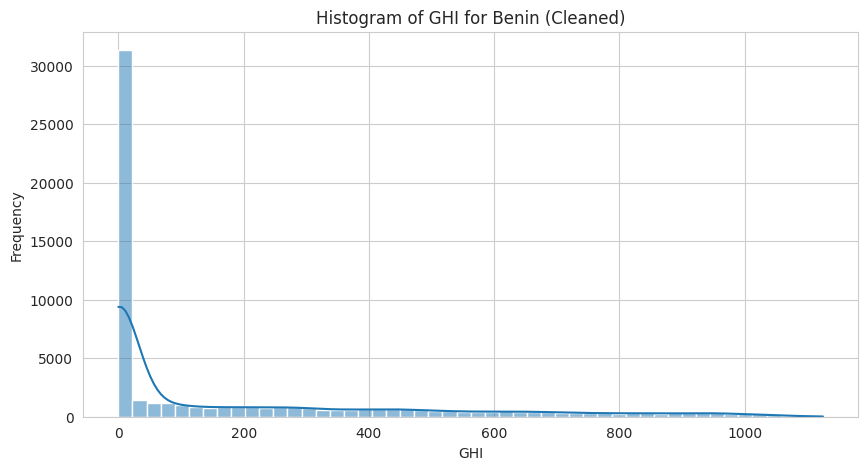

Descriptive stats for GHI:
count    56720.000000
mean       180.269794
std        275.298717
min          0.000000
25%          0.000000
50%          0.000000
75%        295.825000
max       1125.000000
Name: GHI, dtype: float64
Skewness for GHI: 1.51
Kurtosis for GHI: 1.19



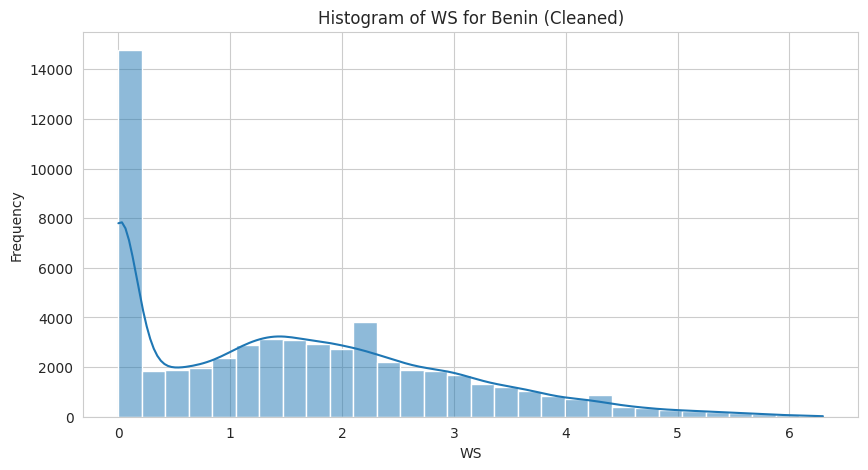

Descriptive stats for WS:
count    56719.000000
mean         1.560278
std          1.358392
min          0.000000
25%          0.200000
50%          1.400000
75%          2.500000
max          6.300000
Name: WS, dtype: float64
Skewness for WS: 0.66
Kurtosis for WS: -0.21



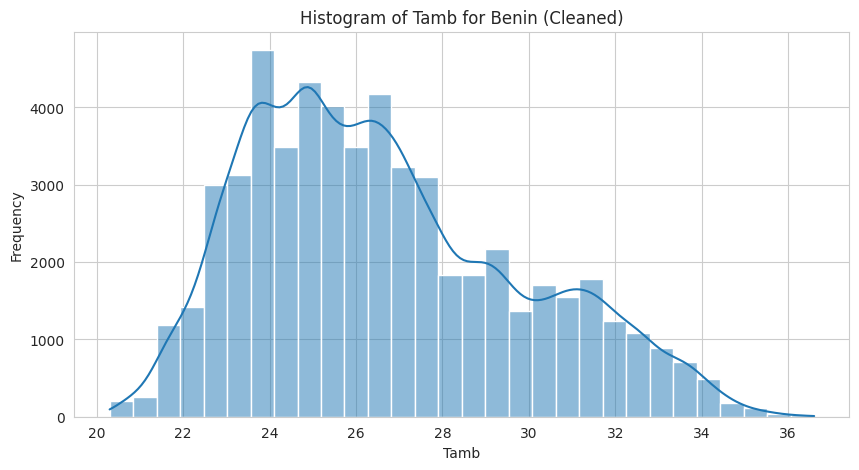

Descriptive stats for Tamb:
count    56720.000000
mean        26.636731
std          3.138287
min         20.300000
25%         24.200000
50%         26.100000
75%         28.700000
max         36.600000
Name: Tamb, dtype: float64
Skewness for Tamb: 0.56
Kurtosis for Tamb: -0.44

--- End of Wind & Distribution Analysis ---


In [34]:
print("\n--- Wind & Distribution Analysis ---")

# --- Plot 1: Wind Rose or Radial Bar Plot (WS/WD) ---
if 'WS' in df_cleaned.columns and 'WD' in df_cleaned.columns and \
   pd.api.types.is_numeric_dtype(df_cleaned['WS']) and \
   pd.api.types.is_numeric_dtype(df_cleaned['WD']):

    # Filter out NaNs specifically for wind rose data
    wind_data_for_rose = df_cleaned[['WS', 'WD']].dropna()

    if not wind_data_for_rose.empty and len(wind_data_for_rose) > 10: # Need some data points
        try:
            # Plotly Express is great for interactive wind roses
            # Bin wind direction for clarity in the rose plot
            wd_bins = np.arange(0, 361, 22.5) # Bins of 22.5 degrees (16 directions)
            wd_labels = (wd_bins[:-1] + wd_bins[1:])/2 # Midpoints of bins for labels
            wind_data_for_rose['WD_binned'] = pd.cut(wind_data_for_rose['WD'], bins=wd_bins, labels=wd_labels, right=False, include_lowest=True)

            fig = px.bar_polar(wind_data_for_rose.dropna(subset=['WD_binned']), # Drop rows where WD_binned is NaN (if any WD outside 0-360)
                               r="WS", theta="WD_binned", # Use binned WD for theta
                               color="WS", # Color by wind speed
                               template="plotly_dark", # Using a dark template
                               title=f'Wind Rose (WS/WD_binned) for {COUNTRY_NAME} (Cleaned)',
                               color_discrete_sequence=px.colors.sequential.Plasma_r) # Color scheme
            fig.show()
        except ImportError:
            print("Plotly not installed. Skipping interactive wind rose. pip install plotly")
        except Exception as e:
            print(f"Could not generate Plotly wind rose: {e}. Trying a basic matplotlib alternative.")
            # Basic matplotlib alternative (less visually appealing as a true wind rose)
            plt.figure(figsize=(8,8))
            ax = plt.subplot(111, projection='polar')
            # Scatter plot for wind direction and speed
            sc = ax.scatter(np.deg2rad(wind_data_for_rose['WD']), wind_data_for_rose['WS'],
                            c=wind_data_for_rose['WS'], cmap='viridis', alpha=0.5, s=10)
            ax.set_theta_zero_location("N")  # Set 0 degrees to North
            ax.set_theta_direction(-1) # Clockwise
            plt.colorbar(sc, label='Wind Speed (m/s)', orientation='vertical', pad=0.1)
            ax.set_title(f'Wind Distribution for {COUNTRY_NAME} (Cleaned)', va='bottom')
            plt.show()
    else:
        print("Not enough valid data for Wind Rose after dropping NaNs in WS/WD or insufficient data points.")
else:
    print("WS or WD columns are missing, not numeric, or no data for Wind Rose in df_cleaned.")


# --- Plot 2: Histograms for GHI and one other variable (e.g., WS) ---
hist_cols = {'GHI': 50} # Column: number of bins
if 'WS' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['WS']):
    hist_cols['WS'] = 30
if 'Tamb' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['Tamb']):
     hist_cols['Tamb'] = 30 # Add Tamb histogram as it's often insightful

for col, bins in hist_cols.items():
    if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
        plt.figure(figsize=(10, 5))
        sns.histplot(df_cleaned[col].dropna(), kde=True, bins=bins)
        plt.title(f'Histogram of {col} for {COUNTRY_NAME} (Cleaned)')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        print(f"Descriptive stats for {col}:")
        print(df_cleaned[col].describe())
        print(f"Skewness for {col}: {df_cleaned[col].skew():.2f}")
        print(f"Kurtosis for {col}: {df_cleaned[col].kurtosis():.2f}\n")
    else:
        print(f"{col} column missing or not numeric for histogram in df_cleaned.")

print("--- End of Wind & Distribution Analysis ---")

# Temperature Analysis (RH influence on Tamb and solar radiation - using df_cleaned)


--- Temperature Analysis (RH Influence) ---


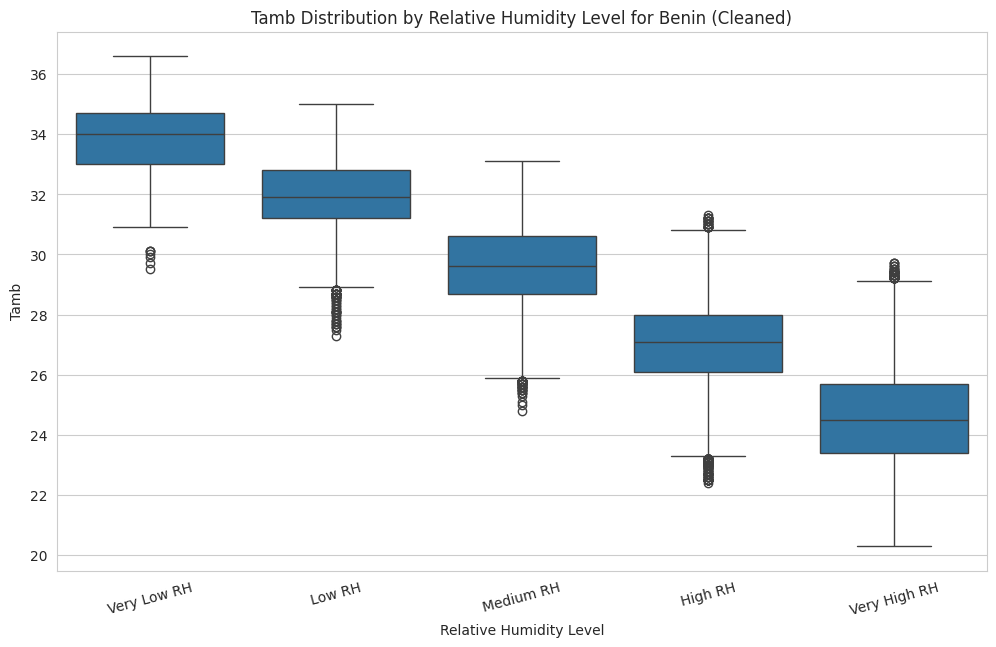

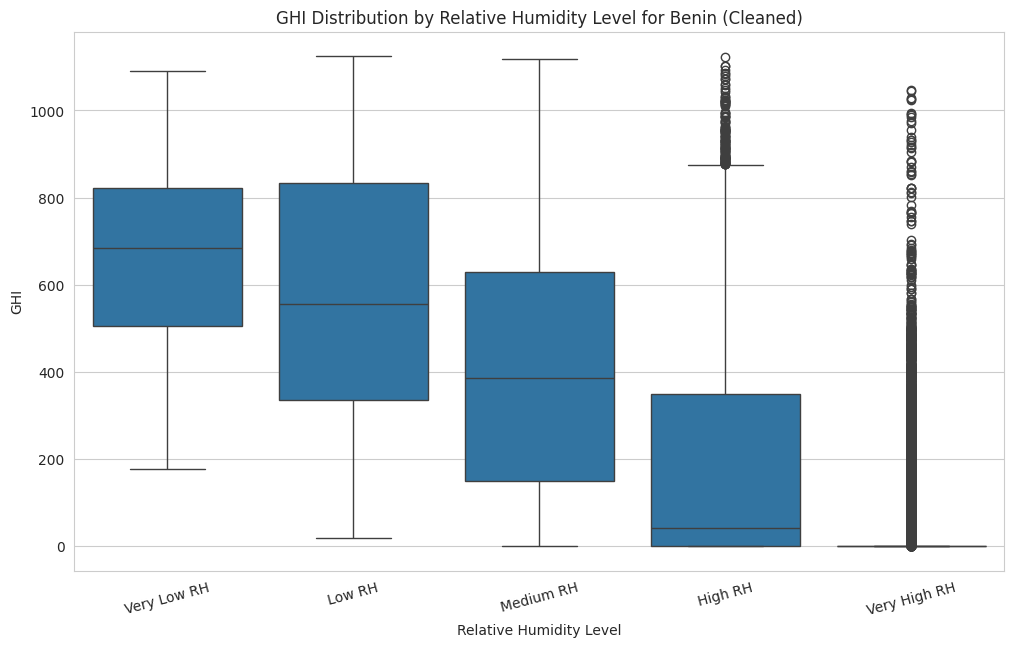

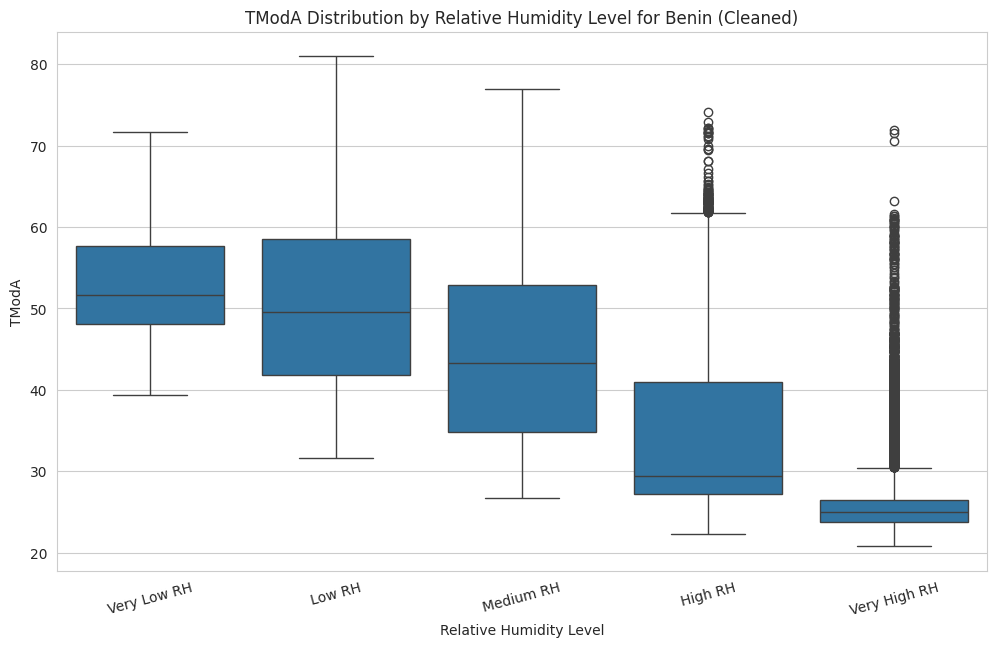

--- End of Temperature Analysis ---


In [35]:


print("\n--- Temperature Analysis (RH Influence) ---")

# We've already plotted RH vs. Tamb and RH vs. GHI in Cell 9.
# Let's use boxplots to see distributions conditional on RH levels.

if 'RH' in df_cleaned.columns and \
   ('Tamb' in df_cleaned.columns or 'GHI' in df_cleaned.columns or \
    'TModA' in df_cleaned.columns or 'TModB' in df_cleaned.columns) and \
   pd.api.types.is_numeric_dtype(df_cleaned['RH']):

    # Create RH bins for easier analysis
    # Ensure RH has enough unique values for meaningful binning
    if df_cleaned['RH'].nunique() > 5: # Arbitrary threshold for enough variation
        try:
            df_cleaned['RH_bins'] = pd.cut(df_cleaned['RH'], bins=5,
                                           labels=['Very Low RH', 'Low RH', 'Medium RH', 'High RH', 'Very High RH'],
                                           include_lowest=True) # include_lowest ensures min value is in a bin

            cols_to_boxplot_vs_rh = []
            if 'Tamb' in df_cleaned.columns: cols_to_boxplot_vs_rh.append('Tamb')
            if 'GHI' in df_cleaned.columns: cols_to_boxplot_vs_rh.append('GHI')
            if 'TModA' in df_cleaned.columns: cols_to_boxplot_vs_rh.append('TModA')
            # Add more if relevant, e.g. TModB

            for col_to_plot in cols_to_boxplot_vs_rh:
                if col_to_plot in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col_to_plot]):
                    plt.figure(figsize=(12, 7))
                    sns.boxplot(data=df_cleaned, x='RH_bins', y=col_to_plot)
                    plt.title(f'{col_to_plot} Distribution by Relative Humidity Level for {COUNTRY_NAME} (Cleaned)')
                    plt.xlabel('Relative Humidity Level')
                    plt.ylabel(col_to_plot)
                    plt.xticks(rotation=15) # Rotate labels slightly if they overlap
                    plt.show()
                else:
                    print(f"Column {col_to_plot} not suitable for boxplot vs RH bins.")

            # Clean up the added column if you don't need it later
            # df_cleaned.drop(columns=['RH_bins'], inplace=True, errors='ignore')

        except Exception as e:
            print(f"Error during binned RH analysis: {e}")
            print("Ensure RH, Tamb, GHI columns are numeric and have sufficient variance.")
    else:
        print("Not enough unique RH values for meaningful binning. Skipping RH binned analysis.")
else:
    print("RH, Tamb, GHI, or TModA columns missing or RH not numeric. Skipping detailed RH influence analysis.")

print("--- End of Temperature Analysis ---")

# Bubble Chart (using df_cleaned and Plotly Express)

In [36]:
#  Bubble Chart (using df_cleaned and Plotly Express)

print("\n--- Bubble Chart ---")
# GHI vs. Tamb with bubble size = RH or BP

bubble_size_col_candidate = ''
# Prefer RH for bubble size if available and suitable
if 'RH' in df_cleaned.columns and \
   pd.api.types.is_numeric_dtype(df_cleaned['RH']) and \
   df_cleaned['RH'].nunique() > 1 and df_cleaned['RH'].min() >= 0: # RH should be positive
    bubble_size_col_candidate = 'RH'
# Fallback to BP if RH is not suitable
elif 'BP' in df_cleaned.columns and \
     pd.api.types.is_numeric_dtype(df_cleaned['BP']) and \
     df_cleaned['BP'].nunique() > 1:
    bubble_size_col_candidate = 'BP'

if 'GHI' in df_cleaned.columns and 'Tamb' in df_cleaned.columns and bubble_size_col_candidate and \
   pd.api.types.is_numeric_dtype(df_cleaned['GHI']) and \
   pd.api.types.is_numeric_dtype(df_cleaned['Tamb']):

    # Sample data for Plotly Express if df_cleaned is very large for better performance
    sample_size_bubble = min(len(df_cleaned), 10000) # Plotly can handle more points than matplotlib scatter
    df_sample_bubble = df_cleaned.sample(n=sample_size_bubble, random_state=42) if len(df_cleaned) > 10000 else df_cleaned

    try:
        fig = px.scatter(df_sample_bubble,
                         x="Tamb",
                         y="GHI",
                         size=bubble_size_col_candidate,  # Column for bubble size
                         color="Tamb",                   # Color points by Ambient Temperature
                         hover_name=df_sample_bubble.index if 'Timestamp' not in df_sample_bubble.columns else df_sample_bubble.get('Timestamp', df_sample_bubble.index).astype(str), # Show index or Timestamp on hover
                         size_max=40,                    # Max bubble size
                         opacity=0.6,
                         title=f'GHI vs. Tamb (Bubble Size: {bubble_size_col_candidate}) for {COUNTRY_NAME} (Cleaned Sample)')
        fig.update_layout(xaxis_title='Ambient Temperature (°C)',
                          yaxis_title='GHI (W/m²)')
        fig.show()
    except ImportError:
        print("Plotly not installed. Skipping interactive bubble chart. pip install plotly")
    except Exception as e:
        print(f"Could not generate Plotly bubble chart: {e}. Trying Seaborn fallback.")
        # Fallback to a Seaborn scatter plot if Plotly fails
        plt.figure(figsize=(12,8))
        sns.scatterplot(data=df_sample_bubble,
                        x='Tamb',
                        y='GHI',
                        size=bubble_size_col_candidate,
                        hue=bubble_size_col_candidate, # Color by bubble size col for Seaborn
                        sizes=(20, 400), # Range of bubble sizes
                        alpha=0.5,
                        legend="auto")
        plt.title(f'GHI vs. Tamb (Size: {bubble_size_col_candidate}) for {COUNTRY_NAME} (Cleaned Sample) - Seaborn Fallback')
        plt.xlabel('Ambient Temperature (°C)')
        plt.ylabel('Global Horizontal Irradiance (GHI)')
        plt.show()
else:
    missing_for_bubble = []
    if 'GHI' not in df_cleaned.columns or not pd.api.types.is_numeric_dtype(df_cleaned.get('GHI')): missing_for_bubble.append('GHI')
    if 'Tamb' not in df_cleaned.columns or not pd.api.types.is_numeric_dtype(df_cleaned.get('Tamb')): missing_for_bubble.append('Tamb')
    if not bubble_size_col_candidate: missing_for_bubble.append('suitable RH/BP')
    print(f"Required columns for Bubble Chart missing or not suitable ({', '.join(missing_for_bubble)}). Skipping.")

print("--- End of Bubble Chart ---")


--- Bubble Chart ---


--- End of Bubble Chart ---
